In [1]:
import matplotlib.pyplot
import numpy
import scipy.stats
import seaborn
import sklearn.metrics

In [2]:
def gen_data(
    m: numpy.ndarray,
    c: numpy.ndarray,
    size: int
) -> tuple[scipy.stats._multivariate.multivariate_normal_gen, numpy.ndarray]:
    rv = scipy.stats.multivariate_normal(mean=m, cov=c)
    data = rv.rvs(size=size, random_state=None)

    return rv, data.T

def disc_fn(mu: numpy.ndarray, c: numpy.ndarray) -> tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray]:
    mu = numpy.reshape(a=mu, newshape=(-1, 1))
    W = -0.5*scipy.linalg.inv(a=c)
    w = scipy.linalg.inv(a=c)@mu
    b = -0.5*mu.T@scipy.linalg.inv(a=c)@mu-0.5*numpy.log(scipy.linalg.det(a=c))+numpy.log(0.5)

    return W, w, b

def plt_decision_boundary(
    rv0: scipy.stats._multivariate.multivariate_normal_gen,
    rv1: scipy.stats._multivariate.multivariate_normal_gen,
    mu0: numpy.ndarray,
    mu1: numpy.ndarray,
    data0: numpy.ndarray,
    data1: numpy.ndarray,
    marker_size: int,
    rad: int,
    num_pts: int,
    levels: int,
    disc_x: numpy.ndarray,
    disc_y: numpy.ndarray,
    label: str,
):
    fig, ax = matplotlib.pyplot.subplots(figsize=(8, 6))
    matplotlib.pyplot.rc(group="font", family="serif")
    matplotlib.pyplot.scatter(x=data0[0, :], y=data0[1, :], s=marker_size, c="cyan", marker='x')
    matplotlib.pyplot.scatter(x=data1[0, :], y=data1[1, :], s=marker_size, c="orange", marker='o')
    seaborn.kdeplot(x=data0[0, :], y=data0[1, :], levels=levels, color="silver", alpha=0.35)
    seaborn.kdeplot(x=data1[0, :], y=data1[1, :], levels=levels, color="silver", alpha=0.35)
    matplotlib.pyplot.plot(disc_x, disc_y, color="magenta", label=label)
    # x, y = numpy.meshgrid(numpy.linspace(start=mu0[0]-rad, stop=mu0[0]+rad, num=num_pts),
    #                       numpy.linspace(start=mu0[1]-rad, stop=mu0[1]+rad, num=num_pts))
    # grid = numpy.dstack(tup=(x, y))
    # pdf_vals = rv0.pdf(x=grid)
    # matplotlib.pyplot.contour(x, y, pdf_vals, levels=levels, colors="silver", alpha=0.5)
    # x, y = numpy.meshgrid(numpy.linspace(start=mu1[0]-rad, stop=mu1[0]+rad, num=num_pts),
    #                       numpy.linspace(start=mu1[1]-rad, stop=mu1[1]+rad, num=num_pts))
    # grid = numpy.dstack(tup=(x, y))
    # pdf_vals = rv1.pdf(x=grid)
    # matplotlib.pyplot.contour(x, y, pdf_vals, levels=levels, colors="silver", alpha=0.5)
    # matplotlib.pyplot.axis("equal")
    matplotlib.pyplot.xlabel(r"$x$")
    matplotlib.pyplot.ylabel(r"$y$")
    matplotlib.pyplot.legend()
    
    matplotlib.pyplot.show()

    return

In [3]:
class PCA():
    def __init__(self, num_components: int):
        self.num_components = num_components
        return

    def _X_mean(self, X: numpy.ndarray) -> numpy.ndarray:
        X_mean = numpy.mean(a=X, axis=1, keepdims=True)   # mean of matrix X  [X, ]
        one_vec = numpy.ones(shape=(1, X.shape[1]))       # [1 x observations]
        X_mean_mat = X_mean@one_vec                       # features mean matrix   [# of features x # of samples]
        X_mean_center = X - X_mean_mat                    # mean-centered matrix X [# of features x # of samples]
        return X_mean_center

    def fit_transform(self, X: numpy.ndarray) -> tuple[numpy.ndarray, numpy.ndarray]:
        X_mean_center = self._X_mean(X=X)
        C = numpy.cov(m=X_mean_center, rowvar=True, bias=False)
        eigenvals, eigenvecs = scipy.linalg.eig(a=C)
        eigenval_indices = numpy.argsort(a=eigenvals)[::-1]
        eigenvals = eigenvals[eigenval_indices].real
        # print(numpy.sum(eigenvals[:84])/numpy.sum(eigenvals))
        eigenvecs = eigenvecs[:, eigenval_indices].real
        Lambda = scipy.linalg.inv(a=numpy.diag(v=numpy.sqrt(eigenvals[:self.num_components])))
        U = eigenvecs[:, :self.num_components]
        W = Lambda@U.T
        Y = W@X_mean_center
        return W, Y

    def reconstruct(self, X: numpy.ndarray) -> numpy.ndarray:
        X_mean_mat, X_mean_center = self._X_mean(X=X)
        Z = self.U[:, :self.num_components].T@X_mean_center
        X_hat = self.U[:, :self.num_components]@Z+X_mean_mat
        return X_hat

In [7]:
class GM():
    def __init__(self) -> None:
        self.mu = None
        self.cov = None
        self.w = None
        return

    def fit(self, X: numpy.ndarray) -> None:
        self.mu = numpy.mean(a=X, axis=1, keepdims=True)
        self.cov = numpy.cov(m=X, rowvar=True)
        self.w = numpy.array([1.0])
        return

    def pdf(self, x: numpy.ndarray) -> float:
        d = x.shape[0]
        const = 1.0/((2.0*scipy.pi)**(d/2.0)*numpy.sqrt(scipy.linalg.det(a=self.cov)))
        exp = -0.5*(x-self.mu).T@scipy.linalg.inv(a=self.cov)@(x-self.mu)
        pdf = const*numpy.exp(exp)
        return pdf

In [10]:
class MNIST_GM():
    def __init__(self, num_components: int, labels: numpy.ndarray, train_pct: float, X: numpy.ndarray) -> None:
        self.pca = PCA(num_components=num_components)
        _, self.Y_pca = self.pca.fit_transform(X=X)
        self.labels = labels
        self.classes = numpy.unique(ar=labels)
        self.train_pct = train_pct
        self.indices_train = None
        self.indices_test = numpy.array([], dtype=numpy.int64)
        self.classifiers = []
        return

    def _split_dataset(self) -> None:
        train_size = self.labels.shape[0]*self.train_pct
        train_cls_size = train_size//self.classes.shape[0]

        indices_train = []
        for cls in self.classes:
            indices_cls = numpy.where(self.labels==cls)[0]
            indices_cls_train = numpy.random.choice(a=indices_cls, size=100, replace=False)
            indices_train.append(indices_cls_train)
            mask = numpy.isin(element=indices_cls, test_elements=indices_cls_train, assume_unique=True)
            self.indices_test = numpy.append(arr=self.indices_test, values=indices_cls[~mask])
        self.indices_train = numpy.vstack(tup=indices_train)

        return

    def train_gaussian(self) -> None:
        self._split_dataset()

        for cls in self.classes:
            gm = GM()
            gm.fit(X=self.Y_pca[:, self.indices_train[cls]])
            self.classifiers.append(gm)

        return

    def predict(self) -> None:
        preds = numpy.array([], numpy.int64)

        for digit in self.Y_pca[:, self.indices_test].T:
            probs = numpy.array([], numpy.float32)
            for classifier in self.classifiers:
                prob = classifier.pdf(x=numpy.reshape(a=digit, newshape=(-1, 1)))
                probs = numpy.append(arr=probs, values=prob)
            pred = numpy.argmax(a=probs)
            preds = numpy.append(arr=preds, values=pred)

        target_names = ["digit 0", "digit 1", "digit 2", "digit 3", "digit 4",
                        "digit 5", "digit 6", "digit 7", "digit 8", "digit 9",]
        cls_rep = sklearn.metrics.classification_report(y_true=labels[self.indices_test], y_pred=preds,
                                                        labels=self.classes, target_names=target_names)
        print(cls_rep)

        return

### Problem 1. Discriminant functions

##### Problem 1 (a)

In [4]:
mu0 = numpy.array(object=[0, 0], dtype=numpy.float32)
c0 = numpy.array(object=[[1, 0], [0, 1]], dtype=numpy.float32)
mu1 = numpy.array(object=[4, 0], dtype=numpy.float32)
c1 = numpy.array(object=[[1, 0], [0, 1]], dtype=numpy.float32)

rv0, data0 = gen_data(m=mu0, c=c0, size=100)
rv1, data1 = gen_data(m=mu1, c=c1, size=100)

W0, w0, b0 = disc_fn(mu=mu0, c=c0)
print("W0", "w0", "b0")
print(W0)
print(w0)
print(b0)

W1, w1, b1 = disc_fn(mu=mu1, c=c1)
print()
print("W1", "w1", "b1")
print(W1)
print(w1)
print(b1)

W0 w0 b0
[[-0.5  0. ]
 [-0.  -0.5]]
[[0.]
 [0.]]
[[-0.6931472]]

W1 w1 b1
[[-0.5  0. ]
 [-0.  -0.5]]
[[4.]
 [0.]]
[[-8.693148]]


\begin{align}
    g_{0}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{0}}^{\intercal}\mathbf{x}+\mathbf{w_{0}}^{\intercal}\mathbf{x}+b_{0} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.5 & 0 \\ 0 & -0.5 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 0 \\ 0\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -0.6931472 \\
    &= -0.5x_{0}^{2}-0.5x_{1}^{2}-0.693148
\end{align}

\begin{align}    
    g_{1}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{1}}^{\intercal}\mathbf{x}+\mathbf{w_{1}}^{\intercal}\mathbf{x}+b_{1} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.5 & 0 \\ 0 & -0.5 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 4 \\ 0\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -8.693148 \\
    &= -0.5x_{0}^{2}-0.5x_{1}^{2}+4x_{0}-8.693148
\end{align}

\begin{align}
    g_{0}(\mathbf{x}) &= g_{1}(\mathbf{x}) \\
    -0.5x_{0}^{2}-0.5x_{1}^{2}-0.693148 &= -0.5x_{0}^{2}-0.5x_{1}^{2}+4x_{0}-8.693148 \\
    4x_{0} &= 8 \\
    x_{0} &= 2
\end{align}

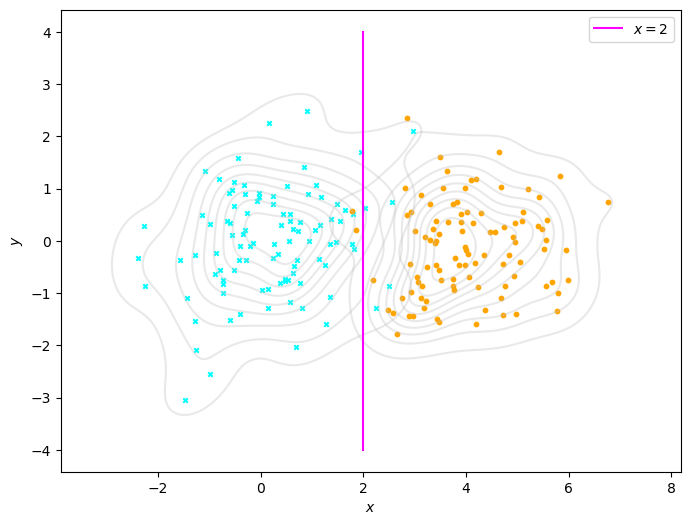

In [5]:
y = numpy.linspace(start=-4, stop=4, num=500)
x = numpy.full(shape=y.shape, fill_value=2)

plt_decision_boundary(
    rv0=rv0,
    rv1=rv1,
    mu0=mu0,
    mu1=mu1,
    data0=data0,
    data1=data1,
    marker_size=10,
    rad=3,
    num_pts=500,
    levels=10,
    disc_x=x,
    disc_y=y,
    label="$x=2$"
)

##### Problem 1 (b)

In [6]:
mu0 = numpy.array(object=[0, 0], dtype=numpy.float32)
c0 = numpy.array(object=[[1, 0], [0, 2]], dtype=numpy.float32)
mu1 = numpy.array(object=[4, 3], dtype=numpy.float32)
c1 = numpy.array(object=[[1, 0], [0, 1]], dtype=numpy.float32)

rv0, data0 = gen_data(m=mu0, c=c0, size=100)
rv1, data1 = gen_data(m=mu1, c=c1, size=100)

W0, w0, b0 = disc_fn(mu=mu0, c=c0)
print("W0", "w0", "b0")
print(W0)
print(w0)
print(b0)

W1, w1, b1 = disc_fn(mu=mu1, c=c1)
print()
print("W1", "w1", "b1")
print(W1)
print(w1)
print(b1)

W0 w0 b0
[[-0.5   0.  ]
 [-0.   -0.25]]
[[0.]
 [0.]]
[[-1.0397208]]

W1 w1 b1
[[-0.5  0. ]
 [-0.  -0.5]]
[[4.]
 [3.]]
[[-13.193148]]


\begin{align}
    g_{0}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{0}}^{\intercal}\mathbf{x}+\mathbf{w_{0}}^{\intercal}\mathbf{x}+b_{0} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.5 & 0 \\ 0 & -0.25 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 0 \\ 0\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -1.0397208 \\
    &= -0.5x_{0}^{2}-0.25x_{1}^{2}-1.0397208
\end{align}

\begin{align}    
    g_{1}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{1}}^{\intercal}\mathbf{x}+\mathbf{w_{1}}^{\intercal}\mathbf{x}+b_{1} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.5 & 0 \\ 0 & -0.5 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 4 \\ 3\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -13.193148 \\
    &= -0.5x_{0}^{2}-0.5x_{1}^{2}+4x_{0}+3x_{1}-13.193148
\end{align}

\begin{align}
    g_{0}(\mathbf{x}) &= g_{1}(\mathbf{x}) \\
    -0.5x_{0}^{2}-0.25x_{1}^{2}-1.0397208 &= -0.5x_{0}^{2}-0.5x_{1}^{2}+4x_{0}+3x_{1}-13.193148 \\
    0.25x_{1}^{2}-3x_{1}+12.1534272 &= 4x_{0} \\
    x_{0} &= \frac{0.25x_{1}^{2}-3x_{1}-12.1534272}{4}
\end{align}

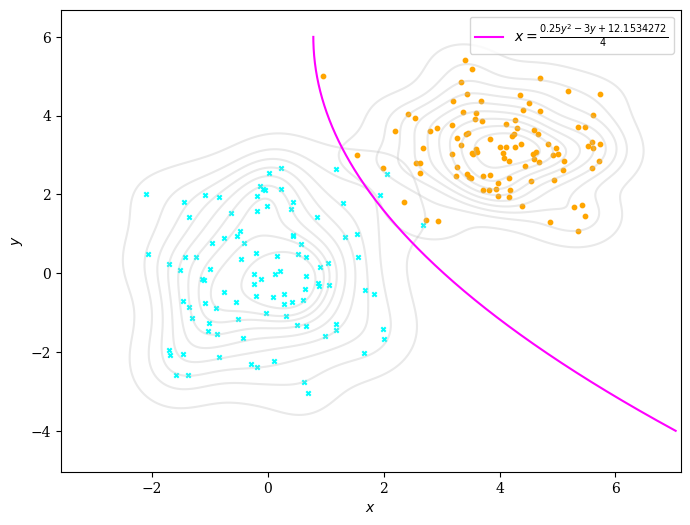

In [7]:
y = numpy.linspace(start=-4, stop=6, num=500)
x = (0.25*y**2-3*y+12.1534272)/4.0

plt_decision_boundary(
    rv0=rv0,
    rv1=rv1,
    mu0=mu0,
    mu1=mu1,
    data0=data0,
    data1=data1,
    marker_size=10,
    rad=3,
    num_pts=500,
    levels=10,
    disc_x=x,
    disc_y=y,
    label="$x=\\frac{0.25y^{2}-3y+12.1534272}{4}$"
)

##### Problem 1 (c)

In [8]:
mu0 = numpy.array(object=[0, 0], dtype=numpy.float32)
c0 = numpy.array(object=[[1, 0], [0, 2]], dtype=numpy.float32)
mu1 = numpy.array(object=[0.5, 0], dtype=numpy.float32)
c1 = numpy.array(object=[[1, 0], [0, 1]], dtype=numpy.float32)

rv0, data0 = gen_data(m=mu0, c=c0, size=100)
rv1, data1 = gen_data(m=mu1, c=c1, size=100)

W0, w0, b0 = disc_fn(mu=mu0, c=c0)
print("W0", "w0", "b0")
print(W0)
print(w0)
print(b0)

W1, w1, b1 = disc_fn(mu=mu1, c=c1)
print()
print("W1", "w1", "b1")
print(W1)
print(w1)
print(b1)

W0 w0 b0
[[-0.5   0.  ]
 [-0.   -0.25]]
[[0.]
 [0.]]
[[-1.0397208]]

W1 w1 b1
[[-0.5  0. ]
 [-0.  -0.5]]
[[0.5]
 [0. ]]
[[-0.8181472]]


\begin{align}
    g_{0}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{0}}^{\intercal}\mathbf{x}+\mathbf{w_{0}}^{\intercal}\mathbf{x}+b_{0} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.5 & 0 \\ 0 & -0.25 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 0 \\ 0\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -1.0397208 \\
    &= -0.5x_{0}^{2}-0.25x_{1}^{2}-1.0397208
\end{align}

\begin{align}    
    g_{1}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{1}}^{\intercal}\mathbf{x}+\mathbf{w_{1}}^{\intercal}\mathbf{x}+b_{1} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.5 & 0 \\ 0 & -0.5 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 0.5 \\ 0\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -0.8181472 \\
    &= -0.5x_{0}^{2}-0.5x_{1}^{2}+0.5x_{0}-0.8181472
\end{align}

\begin{align}
    g_{0}(\mathbf{x}) &= g_{1}(\mathbf{x}) \\
    -0.5x_{0}^{2}-0.25x_{1}^{2}-1.0397208 &= -0.5x_{0}^{2}-0.5x_{1}^{2}+0.5x_{0}-0.8181472 \\
    0.25x_{1}^{2}-0.2215736 &= 0.5x_{0} \\
    x_{0} &= \frac{0.25x_{1}^{2}-0.2215736}{0.5}
\end{align}

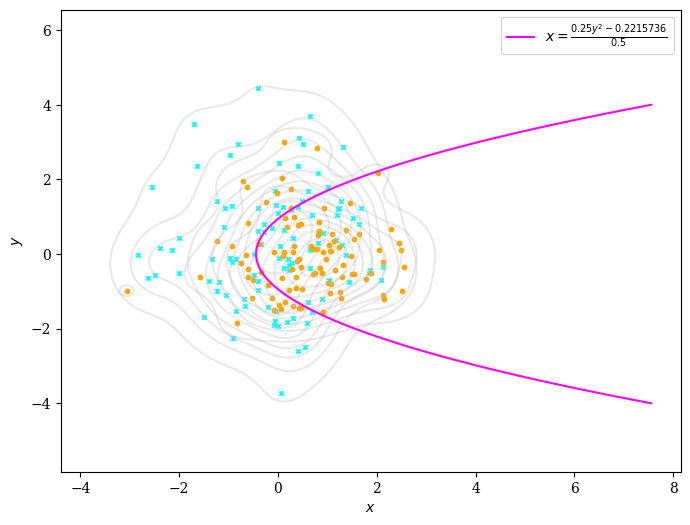

In [9]:
y = numpy.linspace(start=-4, stop=4, num=500)
x = (0.25*y**2-0.2215736)/0.5

plt_decision_boundary(
    rv0=rv0,
    rv1=rv1,
    mu0=mu0,
    mu1=mu1,
    data0=data0,
    data1=data1,
    marker_size=10,
    rad=3,
    num_pts=500,
    levels=10,
    disc_x=x,
    disc_y=y,
    label="$x=\\frac{0.25y^{2}-0.2215736}{0.5}$"
)

##### Problem 1 (d)

In [10]:
mu0 = numpy.array(object=[0, 0], dtype=numpy.float32)
c0 = numpy.array(object=[[1, 0], [0, 2]], dtype=numpy.float32)
mu1 = numpy.array(object=[4, 0], dtype=numpy.float32)
c1 = numpy.array(object=[[2, 0], [0, 1]], dtype=numpy.float32)

rv0, data0 = gen_data(m=mu0, c=c0, size=100)
rv1, data1 = gen_data(m=mu1, c=c1, size=100)

W0, w0, b0 = disc_fn(mu=mu0, c=c0)
print("W0", "w0", "b0")
print(W0)
print(w0)
print(b0)

W1, w1, b1 = disc_fn(mu=mu1, c=c1)
print()
print("W1", "w1", "b1")
print(W1)
print(w1)
print(b1)

W0 w0 b0
[[-0.5   0.  ]
 [-0.   -0.25]]
[[0.]
 [0.]]
[[-1.0397208]]

W1 w1 b1
[[-0.25  0.  ]
 [-0.   -0.5 ]]
[[2.]
 [0.]]
[[-5.039721]]


\begin{align}
    g_{0}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{0}}^{\intercal}\mathbf{x}+\mathbf{w_{0}}^{\intercal}\mathbf{x}+b_{0} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.5 & 0 \\ 0 & -0.25 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 0 \\ 0\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -1.039721 \\
    &= -0.5x_{0}^{2}-0.25x_{1}^{2}-1.039721
\end{align}

\begin{align}    
    g_{1}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{1}}^{\intercal}\mathbf{x}+\mathbf{w_{1}}^{\intercal}\mathbf{x}+b_{1} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.25 & 0 \\ 0 & -0.5 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 2 \\ 0\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -5.039721 \\
    &= -0.25x_{0}^{2}-0.5x_{1}^{2}+2x_{0}-5.039721
\end{align}

\begin{align}
    g_{0}(\mathbf{x}) &= g_{1}(\mathbf{x}) \\
    -0.5x_{0}^{2}-0.25x_{1}^{2}-1.039721 &= -0.25x_{0}^{2}-0.5x_{1}^{2}+2x_{0}-5.039721 \\
    -0.25x_{0}^{2}-2x_{0} &= -0.25x_{1}^{2}-4 \\
    0.25x_{0}^{2}+2x_{0} &= 0.25x_{1}^{2}+4 \\
    x_{0}^{2}+8x_{0} &= x_{1}^{2}+16 \\
    x_{0}^{2}+8x_{0}+16 &= x_{1}^{2}+32 \\
    (x_{0}+4)^{2} &= x_{1}^{2}+32 \\
    x_{0}+4 &= \pm\sqrt{x_{1}^{2}+32} \\
    x_{0} &= -4\pm\sqrt{x_{1}^{2}+32} \\
    x_{0} &= -4+\sqrt{x_{1}^{2}+32}
\end{align}

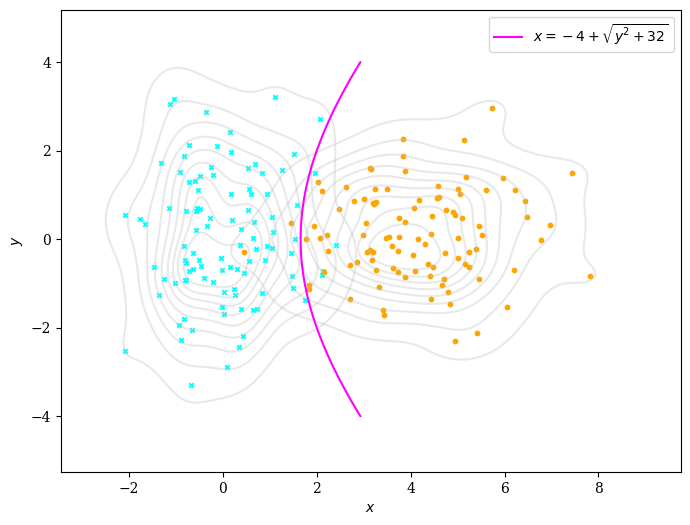

In [11]:
y = numpy.linspace(start=-4, stop=4, num=500)
x = -4+(y**2+32)**0.5

plt_decision_boundary(
    rv0=rv0,
    rv1=rv1,
    mu0=mu0,
    mu1=mu1,
    data0=data0,
    data1=data1,
    marker_size=10,
    rad=3,
    num_pts=500,
    levels=10,
    disc_x=x,
    disc_y=y,
    label="$x=-4+\sqrt{y^{2}+32}$"
)

### Problem 2. Handwritten digit recognition

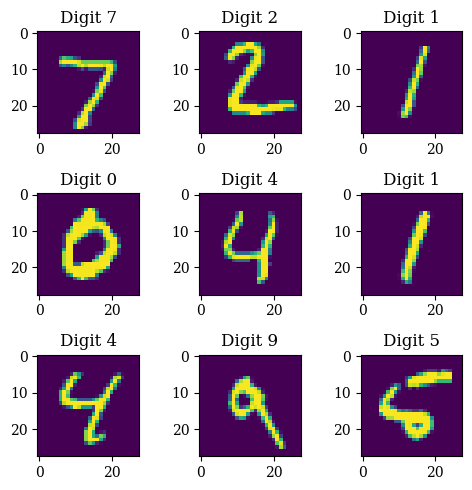

In [4]:
f = numpy.load(file="digits-labels.npz")

digits = f['d']     # [vec(digit) x # of digits]    [(28x28) x 10000] 
labels = f['l']     # [# of digits]                 [10000]           

matplotlib.pyplot.rc('font', family='serif')
fig, axs = matplotlib.pyplot.subplots(3, 3, figsize=(5, 5))
matplotlib.pyplot.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.0, hspace=0.0)

idx = 0
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(X=numpy.reshape(a=digits[:, idx], newshape=(28, 28), order='F'))
        axs[i, j].set_title(rf"Digit %s" % str(labels[idx]))
        idx += 1

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [14]:
mnist_gm = MNIST_GM(num_components=13, labels=labels, train_pct=0.1, X=digits)
mnist_gm.train_gaussian()
mnist_gm.predict()

              precision    recall  f1-score   support

     digit 0       0.94      0.97      0.96       880
     digit 1       0.99      0.95      0.97      1035
     digit 2       0.91      0.91      0.91       932
     digit 3       0.88      0.89      0.88       910
     digit 4       0.90      0.93      0.91       882
     digit 5       0.90      0.86      0.88       792
     digit 6       0.95      0.93      0.94       858
     digit 7       0.89      0.91      0.90       928
     digit 8       0.84      0.83      0.83       874
     digit 9       0.85      0.85      0.85       909

    accuracy                           0.90      9000
   macro avg       0.90      0.90      0.90      9000
weighted avg       0.91      0.90      0.90      9000



### Problem 4. A pool detector 